In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('NWL.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-24,52.869999,52.950001,52.490002,52.599998,48.532166,3167600
1,2017-07-25,52.830002,53.110001,52.610001,52.950001,48.855099,2741100
2,2017-07-26,53.080002,53.090000,52.689999,52.750000,48.670563,1671500
3,2017-07-27,52.730000,52.840000,51.990002,52.139999,48.107742,3061000
4,2017-07-28,52.000000,52.459999,51.910000,52.070000,48.043156,2010600


In [4]:
data.count()

Date         502
Open         502
High         502
Low          502
Close        502
Adj Close    502
Volume       502
dtype: int64

In [5]:
count = data['Date'].count()
# train_count = int(count * .8)

# y_train = data[['Date', 'Close']][:train_count]
# y_test = data[['Date', 'Close']][train_count:]

y_train = data[['Date', 'Close']][count - 30 - 365:count - 30]
y_test = data[['Date', 'Close']][-30:]

test_count = y_test['Date'].count()

y_train_plt = y_train.set_index('Date')
y_test_plt = y_test.set_index('Date')

y_train_plt.sort_index(inplace=True)
y_test_plt.sort_index(inplace=True)

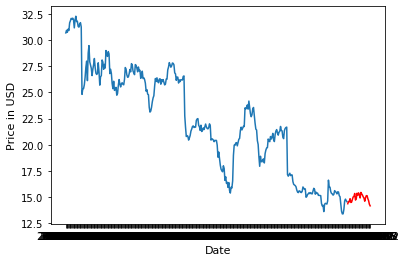

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(y_train_plt)
plt.plot(y_test_plt, color='Red')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Price in USD', fontsize=11)
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):
    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(x, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
        if result[0]>value:
            print("The graph is non stationary")
            break
        else:
            print("The graph is stationary")
            break
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))

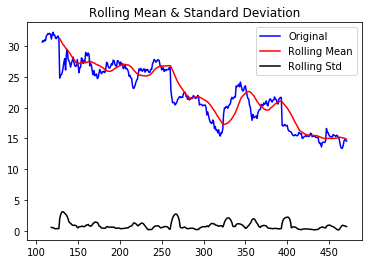

ADF Stastistic: -1.438853
p-value: 0.563514
The graph is non stationary
Critical values:
	1%: -3.448 
	5%: -2.870 
	10%: -2.571 


In [8]:
test_stationarity(y_train['Close'])

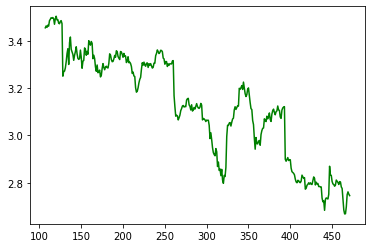

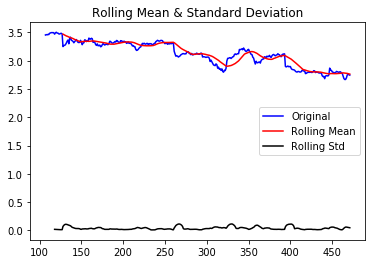

ADF Stastistic: -1.148124
p-value: 0.695504
The graph is non stationary
Critical values:
	1%: -3.448 
	5%: -2.870 
	10%: -2.571 


In [9]:
ts_log = np.log1p(y_train['Close'])
plt.plot(ts_log,color="green")
plt.show()

test_stationarity(ts_log)

In [10]:
ts_log[:5]

107    3.455370
108    3.463233
109    3.457263
110    3.466673
111    3.462606
Name: Close, dtype: float64

In [11]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff[:5]

107         NaN
108    0.007863
109   -0.005970
110    0.009410
111   -0.004067
Name: Close, dtype: float64

In [12]:
ts_log_clone = ts_log.copy()
rolling_val = ts_log[0]
for idx, value in ts_log_diff.iteritems():
    if not np.isnan(value):
        rolling_val = rolling_val + value
        ts_log_clone[idx] = rolling_val

KeyError: 0

In [ ]:
ts_log_clone[:5]

In [ ]:
sum((ts_log_clone-ts_log)**2)

In [ ]:
ts_log_clone.count()

In [ ]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

results = []
for a in range(4):
    for b in range(4):
        for c in range(4):
#             model = ARIMA(ts_log, order=(1,1,0))
            try:
                model = ARIMA(ts_log, order=(a,b,c))
                results_ARIMA = model.fit(disp=-1)
                model_rss = sum((results_ARIMA.fittedvalues-ts_log_diff)**2)
                if not np.isnan(model_rss):
                    print('a={}, b={}, c={} - RSS={}'.format(a, b, c, model_rss))
                    results.append({
                        'params': (a, b, c),
                        'model': model,
                        'results': results_ARIMA,
                        'rss': model_rss
                    })
            except:
                pass

max_score = min([item['rss'] for item in results if not np.isnan(item['rss'])])
best_result = [item for item in results if item['rss'] == max_score][0]
print('Best fit: {}, params: {}'.format(max_score, best_result['params']))

plt.plot(ts_log_diff)
plt.plot(best_result['results'].fittedvalues, color='red')
# plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [ ]:
results_ARIMA.fittedvalues.count()

In [ ]:
ts_log_arima = ts_log.copy()
data_with_dates = data[['Date', 'Close']].copy()
data_with_dates['Preds'] = np.nan
data_with_dates['Close_Train'] = np.nan
data_with_dates['Close_Test'] = np.nan
data_with_dates.set_index('Date')
# data_with_dates.head()

# rolling_val = ts_log[0]
data_with_dates.at[0, 'Preds'] = ts_log[0]
last_idx = 0
for idx, value in best_result['results'].fittedvalues.iteritems():
    last_idx = idx
    if not np.isnan(value):
#         rolling_val = rolling_val + value
#         print(data_with_dates['Preds'][idx - 1] + value)
#         print(value)
        data_with_dates.at[idx, 'Preds'] = data_with_dates['Preds'][idx - 1] + value

# forecast_values = best_result['results'].forecast(test_count)[0]
forecast_values = best_result['results'].predict(start=last_idx, end=last_idx + test_count)
# print(forecast_values)
for idx, value in enumerate(forecast_values):
    if not np.isnan(value):
        target_idx = idx + last_idx
#         print(data_with_dates['Preds'][target_idx])
        data_with_dates.at[target_idx + 1, 'Preds'] = data_with_dates['Preds'][target_idx] + value

data_with_dates[['Preds']] = np.expm1(data_with_dates['Preds'])
data_with_dates.loc[:train_count, 'Close_Train'] = y_train['Close']
data_with_dates.loc[train_count:, 'Close_Test'] = y_test['Close']

In [ ]:
data_with_dates.tail()

In [ ]:
plt.plot(data_with_dates[['Preds']])
plt.plot(data_with_dates[['Close_Train']])
plt.plot(data_with_dates[['Close_Test']])
# plt.xlabel('Date', fontsize=11)
# plt.ylabel('Price in USD', fontsize=11)
# plt.plot(ts_log_arima, color='Red')
plt.show()

In [ ]:
plt.plot(y_train['Close'])
for result in results:
    ts_log_arima = ts_log.copy()
    # rolling_val = ts_log[0]
    for idx, value in result['results'].fittedvalues.iteritems():
        if not np.isnan(value):
    #         rolling_val = rolling_val + value
            ts_log_arima[idx + 1] = ts_log_arima[idx] + value

    ts_log_arima = np.expm1(ts_log_arima)
    plt.plot(ts_log_arima)
plt.show()

In [ ]:
class StocksEnv:
    
    def __init__(self, data, history_t=180, data_key='Close'):
        self.data = data
        self.history_t = history_t
        self.data_key = data_key
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :][self.data_key])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :][self.data_key] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :][self.data_key] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :][self.data_key] - self.data.iloc[(self.t-1), :][self.data_key])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [ ]:
env = StocksEnv(data)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))